# Setup

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *
# from ACSPaper.Matching import *
from ACSPaper.ACSPaperUtils import *
from sklearn.metrics import roc_curve, auc
import shap
from sklearn.model_selection import train_test_split

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/ACS_study/v2/'
curr_dir = os.path.join(paper_dir, 'specific_mb-metabolite_pathway')
make_dir_if_not_exists(curr_dir)
os.chdir(paper_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

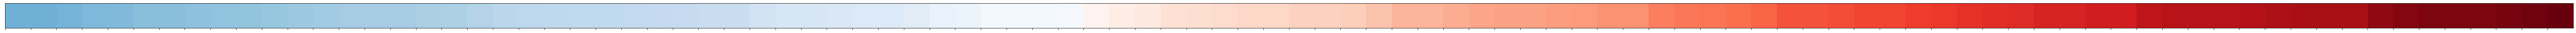

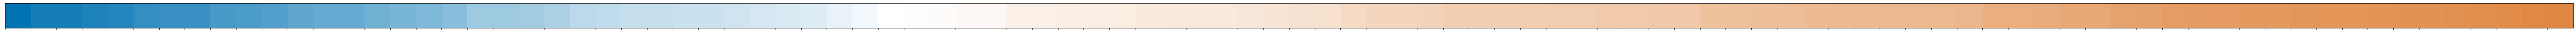

In [21]:
from matplotlib.colors import Normalize

def change_index(data, df, from_idx, to_idx):
    c_name = data.columns.names
    data = data.reset_index().merge(df.reset_index()[[from_idx, to_idx]], on=from_idx).set_index(to_idx).copy()
    del data[from_idx]
    data = data.loc[data.index.notnull()]
    data.columns.names = c_name
    return data

def _get_scale_colors(cmaps, data, zero_is_middle=True, base_n=300, boundries=None, return_cmap=False):
    if boundries is None:
        data_plus_min = data - min(0, data.min())
        data_plus_min /= data_plus_min.max()
        min_max_ratio = abs(data.min() / float(data.max()))
    else:
        data_plus_min = data + abs(boundries[0])
        data_plus_min /= (abs(boundries[0]) + boundries[1])
        min_max_ratio = abs(boundries[0] / float(boundries[1]))
    if len(cmaps) == 1:
        return [cmaps[0](i) for i in data_plus_min]

    colors1 = cmaps[0](np.linspace(0., 1, int(base_n*min_max_ratio)))
    colors2 = cmaps[1](np.linspace(0., 1, base_n))
    # combine them and build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    if return_cmap:
        return mymap
    return [mymap(i) for i in data_plus_min]

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

sns.palplot(_get_scale_colors([plt.cm.Blues_r, plt.cm.Reds], np.sort(np.random.uniform(-0.5, 0.5, 100)), boundries=[-1, 0.5] ))

from matplotlib.colors import LinearSegmentedColormap
cm_acs = LinearSegmentedColormap.from_list('acs', ['white', acs_color], N=1000)
cm_healthy = LinearSegmentedColormap.from_list('healthy', [healthy_color, 'white'], N=1000)
sns.palplot(_get_scale_colors([cm_healthy, cm_acs], np.sort(np.random.uniform(-10, 30, 100)), boundries=[-10, 40] ))

# Load data

In [22]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')
pnp_data = pnp_data[pnp_data.IsGenotek == 0]
pnp_data = pnp_data[pnp_data.Nextera == 'True']
acs_data['ACS sample'] = 1
pnp_data['ACS sample'] = 0

pnp_data_metabolon = pd.read_csv(os.path.join(paper_dir, 'data', 'pnp_data_metabolon.csv'), index_col=0)
acs_data_metabolon = pd.read_csv(os.path.join(paper_dir, 'data', 'acs_data_metabolon.csv'), index_col=0)
updated_metabs1 = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v4/dataframes/updated_metabs1.csv', index_col=0)
updated_metabs2 = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v4/dataframes/updated_metabs2.csv', index_col=0)
# circ_heatmap_df_sorted = pd.read_csv(os.path.join(paper_dir, 'serum_metabolomics_signatures', 'metabolon', 'circ_heatmap_df_sorted.csv'), index_col=0)
circ_heatmap_df_sorted = pd.read_csv(os.path.join(paper_dir, 'serum_metabolomics_signatures', 'metabolon', 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0)
full_shap = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_full_model/abs_signed_shap.csv', index_col=0)
unknowns_sp = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v5/unknown_pathway_prediction/Supplementary_unknowns_sub_pathways_all_features+shap+levels.csv', index_col=0)
metabolon_df = pd.read_csv(os.path.join(paper_dir, 'data', 'metabolon_df.csv'), index_col=[0, 1]).drop('SerumName', axis=1)

Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (43,3236,3261) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (1,10,23,30,40,96,107,110,111,112,131,132,133,134,135,136,137,138,139,140,141,142,143,145,148,149,150,151,152,153,155,157,159,169,170,179,184,3212) have mixed types.Specify dtype option on import or set low_memory=False.


In [23]:
# matched_samples = pd.read_csv(os.path.join(paper_dir, 'Matching', 'PNP1-ACS_matching', 'PNP1-ACS_nextera_age+sex_matched_1:1.csv'), index_col=0)
matched_samples = pd.read_csv(os.path.join(paper_dir, 'Matching', 'PNP1-ACS_matching', 'PNP1-ACS_microbiome_age+sex+bmi+DM+smoking_1:1.csv'), index_col=0)
matched_pnp_data = pnp_data_metabolon.loc[matched_samples[matched_samples['ACS sample'] == 0].index]
matched_acs_data = acs_data_metabolon.loc[matched_samples[matched_samples['ACS sample'] == 1].index]

In [24]:
storage_bad_metabs = pd.read_pickle(os.path.join('../data', 'storage_time_bad_metabs_bonf.pkl'))

## MetaCardis

In [25]:
metacardis_dir = os.path.join('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/MetaCardis')
metacardis_X_path = os.path.join(metacardis_dir, 'dataframes', 'mb_diet_covariates_drugs_group.csv')
metacardis_metabolomics_path = os.path.join(metacardis_dir, 'metabolomics', 'robust_zs_metabolomics/proc_metabolomics_clipped.csv')
metacardis_X = pd.read_csv(metacardis_X_path, index_col=0)
metacardis_metadata_path = os.path.join(metacardis_dir, 'metabolomics', 'metadata', 'hub.metadata_reduced.samples.v10.r')
metacardis_X = metacardis_X.merge(pd.read_csv(metacardis_metadata_path, sep='\t', index_col=0)[['PATGROUPFINAL_C']], on='SampleID', how='left')
metacardis_X_age_bmi = metacardis_X[['AGE', 'BMI_C', 'Group']].copy()
metacardis_metabolomics = pd.read_csv(metacardis_metabolomics_path, index_col=0)
print (set([s.split('___')[0] for s in metacardis_metabolomics.columns]))
metacardis_serum_metabolomics = metacardis_metabolomics.loc[:, ['urine' not in s.split('___')[0] for s in metacardis_metabolomics.columns]].dropna()
# metacardis_serum_metabolomics = metacardis_metabolomics.filter(regex='hub.lipo.samples.v3.r')
full_index = list(set(metacardis_serum_metabolomics.index).intersection(set(metacardis_X_age_bmi.index)))
metacardis_serum_metabolomics, metacardis_X_age_bmi = metacardis_serum_metabolomics.loc[full_index].astype(float), metacardis_X_age_bmi.loc[full_index]
metacardis_serum_metabolomics.index.names = ['SampleID']
metacardis_X_age_bmi.Group.value_counts()

{'hub.serum_tmao.v1.samples.r', 'hub.serum_absolute.v1.samples.r', 'hub.urine_annotated.samples.v2.r', 'hub.lipo.samples.v3.r'}


IHD372     269
HC275      225
MMC269     188
UMCC222    159
Name: Group, dtype: int64

# bacteria-metabolite correlations

['100001251',
 '100001320',
 '100000008',
 '100000776',
 '1090',
 '100006126',
 '821',
 '100005391',
 '100009225',
 '100015791',
 '100001540',
 '2049',
 '501',
 '363',
 '1084',
 '100001412',
 '818',
 '100001278',
 'X - 15461',
 '100000665',
 '71',
 'X - 16938',
 'X - 21829',
 '100001423',
 '1123',
 '100001733',
 '100015962',
 '100003926',
 '1002',
 '1528',
 '2054',
 '100001211',
 '100009334',
 'X - 11261',
 '100001083',
 '100004561',
 '100001570',
 '100000773',
 '100006435',
 '180',
 '100015882',
 '397',
 '100001755',
 '100002951',
 '310',
 'X - 11372',
 '100004322',
 '252',
 '100009002',
 '100001126',
 'X - 15666',
 'X - 21792',
 '100001397',
 '100001739',
 'X - 11847',
 '100015788',
 'X - 12212',
 '482',
 '100001409',
 '100006438',
 '100001999',
 '100009069',
 'X - 17653',
 '100020419',
 '100001468',
 '100001396',
 '100002784',
 '100001162',
 '100005463',
 '100001767',
 '1162',
 'X - 12472',
 'X - 24293',
 '925',
 '100002029',
 '100001055',
 '100006282',
 '100015831',
 '100000846',
 '100001391',
 '535',
 '566',
 '100003674',
 'X - 24328',
 '799',
 '100015789',
 '878',
 '100000787',
 '100015787',
 '100001007',
 '100016069',
 '100001212',
 '848',
 'X - 12849',
 'X - 24425',
 '100001395',
 '100000042',
 '1113',
 '179',
 '100020497',
 '1110',
 '849',
 'X - 12104',
 '100009005',
 '1025',
 'X - 21342',
 'X - 11858',
 'X - 24527',
 '100002129',
 '100006290',
 '1206',
 '100001034',
 '1668',
 '100006203',
 '100020822',
 '100000840',
 '100001415',
 '100002761',
 '376',
 '892',
 'X - 24809',
 '100001300',
 '100020425',
 'X - 21319',
 'X - 23583',
 '100008957',
 '100006296',
 '100002009',
 'X - 17685',
 '100006191',
 '100015845',
 '100008998',
 '100001207',
 '100006293',
 '1102',
 '182',
 'X - 18886',
 '100009162',
 '356',
 '100008954',
 '445',
 '100001791',
 '100001882',
 '100002241',
 '1258',
 '100006379',
 'X - 13684',
 '100005403',
 '100009028',
 'X - 12730',
 '100000961',
 '100001731',
 '100002796',
 '914',
 'X - 11795',
 '100005850',
 '100001148',
 '100001604',
 '100008990',
 '100001956',
 'X - 15469',
 '100015620',
 '100009130',
 '267',
 'X - 21821',
 '62',
 '297',
 'X - 24849',
 '100004046',
 'X - 17327',
 '100001989',
 '100020004',
 '100001359',
 'X - 23666',
 '100001580',
 '100010923',
 '100001993',
 '100019975',
 '100020912',
 '273',
 '880',
 'X - 12117',
 'X - 23680',
 '1134',
 '100008903',
 '212',
 '100001274',
 'X - 21442',
 '100000295',
 'X - 23997',
 'X - 24951',
 '100006620',
 'X - 21258',
 'X - 18779',
 '917',
 '100000870',
 '100001416',
 '100002344',
 'X - 16397',
 'X - 12544',
 '100001551',
 'X - 21383',
 '1537',
 'X - 23294',
 '100001977',
 '100001843',
 '100015760',
 '100006116',
 'X - 16580',
 '1140',
 '100006098',
 'X - 21607',
 '100008928',
 '100000258',
 'X - 16944',
 '100006642',
 '1053',
 '112',
 '100015836',
 '100000657',
 '100001048',
 '827',
 '100001509',
 '100000784',
 '932',
 '100009131',
 '100009345',
 '100021000',
 '100002462',
 '100001294',
 '100002249',
 '100001405',
 '935',
 '424',
 '100001876',
 '100020241',
 '100009275',
 'X - 21411',
 'X - 12740',
 'X - 12851',
 '100008904',
 'X - 12127',
 '100004523',
 '503',
 'X - 11381',
 'X - 17351',
 '100001778',
 '393',
 '100001276',
 '100020910',
 '498',
 '891',
 '100001988',
 '881',
 '100006298',
 '100001181',
 '100002568',
 '1538',
 '98',
 '100005985',
 '100006171',
 'X - 19438',
 '100009014',
 '100001322',
 '415',
 'X - 17357',
 '100001277',
 '444',
 '266',
 'X - 15245',
 '100003470',
 '825',
 '100000616',
 '100009025',
 'X - 23644',
 'X - 24411',
 '100009394',
 '100020014',
 '100001393',
 'X - 21470',
 '100003260',
 '100015623',
 '100001501',
 '100015790',
 'X - 17328',
 'X - 23593',
 '100001612',
 'X - 17335',
 '1024',
 '1254',
 '100003000',
 '100004635',
 '100020205',
 '100001125',
 '504',
 '100020427',
 '1052',
 '100020215',
 'X - 12729',
 '1124',
 '100005389',
 'X - 22162',
 '100020423',
 '100002990',
 '100001856',
 '100001869',
 '100002102',
 'X - 12812',
 '100001593',
 '100001511',
 '100001086',
 '254',
 '826',
 'X - 16654',
 'X - 21353',
 '1128'

In [26]:
k = 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__unknown|s__unknown|fSGB__1439|gSGB__3527|sSGB__4712'
# k = 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_hadrus|fSGB__1413|gSGB__3421|sSGB__4540'
kp = pnp_data_metabolon.loc[:, list(set(metabolon_df.columns) - set(storage_bad_metabs))].astype(float)\
            .apply(lambda x: spearmanr(x, pnp_data_metabolon[k], nan_policy='omit')[1]).sort_values()
kr = pnp_data_metabolon.loc[:, list(set(metabolon_df.columns) - set(storage_bad_metabs))].astype(float)\
            .apply(lambda x: spearmanr(x, pnp_data_metabolon[k], nan_policy='omit')[0]).sort_values()

In [27]:
fdr_correction(kp, alpha=0.05)[0].sum()
# used_metabs = kp[fdr_correction(kp, alpha=0.01)[0]].index
# used_metabs

23

In [28]:
df_temp = pd.concat((updated_metabs1.loc[used_metabs, ['BIOCHEMICAL', 'SUB_PATHWAY']], 
               circ_heatmap_df_sorted.loc[used_metabs, 'Healthy-ACS'],
               kr.loc[used_metabs].rename('Correlation with bacteria')), axis=1)
df_temp['SUB_PATHWAY'].fillna(unknowns_sp.reindex(used_metabs).idxmax(1), inplace=True)
print (spearmanr(df_temp['Correlation with bacteria'], df_temp['Healthy-ACS']))
# df_temp = df_temp[df_temp['Healthy-ACS'].apply(lambda x: 10**(-abs(x)))<0.05]
df_temp.to_csv(os.path.join(curr_dir, 'SGB4712_correlations.csv'))
df_temp

SpearmanrResult(correlation=-0.914285714285714, pvalue=1.8531121308926519e-06)


,BIOCHEMICAL,SUB_PATHWAY,Healthy-ACS,Correlation with bacteria
100006191,p-cresol-glucuronide*,Tyrosine Metabolism,2.698843,-0.326346
100001315,p-cresol sulfate,Benzoate Metabolism,0.719160,-0.302568
X - 23997,X - 23997,Benzoate Metabolism,2.271898,-0.263596
100000011,phenylacetate,Phenylalanine Metabolism,0.380995,-0.245748
100001417,phenylacetylglutamine,Acetylated Peptides,0.203488,-0.236824
X - 11843,X - 11843,Tryptophan Metabolism,0.624293,-0.235235
X - 11850,X - 11850,Tryptophan Metabolism,0.010422,-0.234544
100004318,indolin-2-one,Food Component/Plant,-0.297747,-0.224704
100000467,3-indoxyl sulfate,Tryptophan Metabolism,-0.313810,-0.217847
X - 21286,X - 21286,Tryptophan Metabolism,0.358907,-0.207758


In [29]:
metacardis_X.Group.value_counts()

IHD372     319
HC275      275
MMC269     218
UMCC222    211
Name: Group, dtype: int64

In [30]:
mb_df = pd.concat((metacardis_X[[k, 'Group']].rename_axis('RegistrationCode'), 
                                matched_pnp_data[[k, 'ACS sample']],
                                matched_acs_data[[k, 'ACS sample']]), axis=0, sort=False)
#                                 pnp_data[[k, 'ACS sample']],
#                                 acs_data[[k, 'ACS sample']]), axis=0, sort=False)

mb_df['Group'].fillna(mb_df['ACS sample'], inplace=True)
mb_df['Group'].replace({'HC275':0, 'IHD372':1, 'MMC269':0.33, 'UMCC222':0.66}, inplace=True)
mb_df['ACS sample'] = ['MetaCardis' if pd.isnull(s) else 'Our cohort' for s in mb_df['ACS sample']]
mb_df.rename(columns={'ACS sample':'Cohort'}, inplace=True)

mb_df

,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__unknown|s__unknown|fSGB__1439|gSGB__3527|sSGB__4712,Group,Cohort
RegistrationCode,,,
x10MCx3300,0.003701,0.66,MetaCardis
x12MCx1639,0.000195,1.00,MetaCardis
x12MCx1893,0.000577,1.00,MetaCardis
x10MCx1668,0.000100,1.00,MetaCardis
x30MCx1902,0.000100,1.00,MetaCardis
...,...,...,...
3972217,0.000100,1.00,Our cohort
3437341,0.000100,1.00,Our cohort
3096233,0.000100,1.00,Our cohort


# Plot

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0 1]
[0 1 2 3]


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


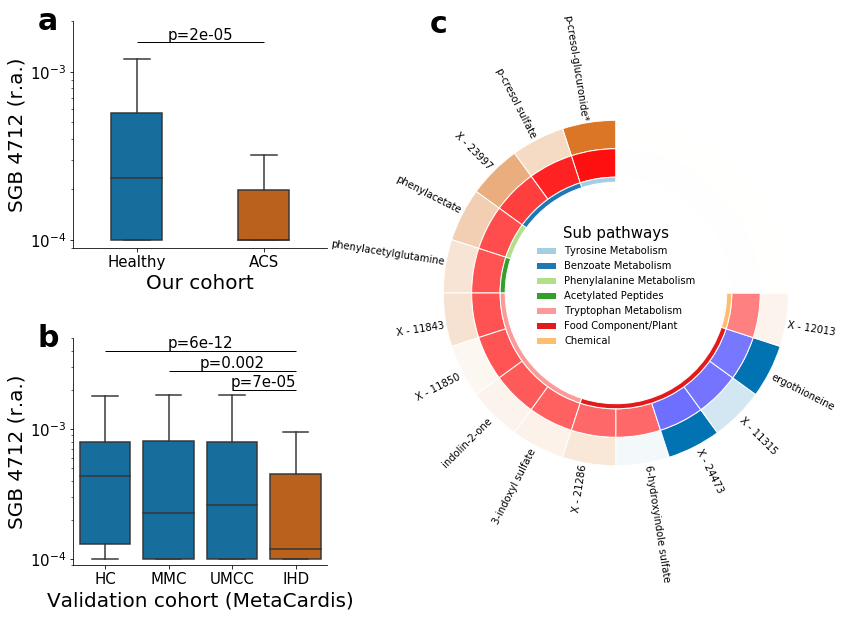

In [249]:
# df = circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS'].abs() > 5].copy()
# df = circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)) < 0.05/circ_heatmap_df_sorted.shape[0]].copy()
df = pd.concat((df_temp, pd.DataFrame(0, index=['']*int(df_temp.shape[0]/3), columns=df.columns)), axis=0, sort=False)
df['BIOCHEMICAL'] = df['BIOCHEMICAL'].replace(0, '')
df['SUB_PATHWAY'] = df['SUB_PATHWAY'].replace(0, '')
df.drop('').to_csv(os.path.join(curr_dir, 'circ_heatmap_df.csv'))

super_pathway_names = df['SUB_PATHWAY'].unique().tolist()
group_size=[df['SUB_PATHWAY'].value_counts().loc[i] for i in super_pathway_names]
 
cmaps = {'Healthy-ACS':[cm_healthy, cm_acs], 'Correlation with bacteria':[plt.cm.bwr_r]}
boundries = {k:None for k in cmaps}
boundries['Healthy-ACS'] = (-7, 7)
boundries['Correlation with bacteria'] = (-0.35, 0.35)
 
# fig, axes = plt.subplots(1, 3, figsize=(19, 7))
label_fontsize=20
tick_fontsize=15

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 5, wspace=.2, hspace=0.4)

our_box = fig.add_subplot(gs[0, :2])
val_box = fig.add_subplot(gs[1, :2])
circ = fig.add_subplot(gs[:, 3:])

# ax = axes[0]
# sns.boxplot(x='Group', y=k, data=mb_df.sort_values('Group'), hue='Cohort', ax=ax, showfliers=False, palette=sns.color_palette('Paired'))
# ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD/ACS'])
# # plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
# ax.set_yscale('log')
# ax.set_ylabel('Relative abundance of SGB 4712', fontsize=label_fontsize)
# ax.set_xlabel('Group', fontsize=label_fontsize)
# ax.tick_params(labelsize=tick_fontsize)
# leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
# ax.set_ylim((9e-5, 2e-2))
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# print (ax.get_xticks())

# t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.66)][k])
# xx=2.3
# ax.text(xx, 0.002,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
# ax.hlines(y=0.002, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')
# t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.33)][k])
# xx=1.8
# ax.text(xx, 0.003,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
# ax.hlines(y=0.003, xmin=xx-1, xmax=xx+1, linewidth=1, color='black')
# t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.)][k])
# xx=1.3
# ax.text(xx, 0.005,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
# ax.hlines(y=0.005, xmin=xx-1.5, xmax=xx+1.5, linewidth=1, color='black')
# t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 0)][k])
# xx=1.7
# ax.text(xx, 0.008,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
# ax.hlines(y=0.008, xmin=xx-1.5, xmax=xx+1.5, linewidth=1, color='black')

ax = our_box
sns.boxplot(x='Group', y=k, data=mb_df[mb_df.Cohort == 'Our cohort'].sort_values('Group'), ax=ax, showfliers=False, palette=[healthy_color, acs_color], width=0.4)
# ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD/ACS'])
ax.set_xticklabels(['Healthy', 'ACS'])
# plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
ax.set_yscale('log')
ax.set_ylabel('SGB 4712 (r.a.)', fontsize=label_fontsize)
ax.set_xlabel('Our cohort', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
ax.set_ylim((9e-5, 2e-3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print (ax.get_xticks())

t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 0)][k])
xx=0.5
ax.text(xx, 0.0015,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.0015, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')

ax = val_box
sns.boxplot(x='Group', y=k, data=mb_df[mb_df.Cohort == 'MetaCardis'].sort_values('Group'), ax=ax, showfliers=False, palette=[healthy_color, healthy_color, healthy_color, acs_color])
ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD'])
# ax.set_xticklabels(['Healthy', 'ACS'])
# plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
ax.set_yscale('log')
ax.set_ylabel('SGB 4712 (r.a.)', fontsize=label_fontsize)
ax.set_xlabel('Validation cohort (MetaCardis)', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
ax.set_ylim((9e-5, 5e-3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print (ax.get_xticks())

t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.66)][k])
xx=2.5
ax.text(xx, 0.002,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.002, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')
t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.33)][k])
xx=2.
ax.text(xx, 0.0028,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.0028, xmin=xx-1, xmax=xx+1, linewidth=1, color='black')
t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.)][k])
xx=1.5
ax.text(xx, 0.004,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.004, xmin=xx-1.5, xmax=xx+1.5, linewidth=1, color='black')
# t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 0)][k])
# xx=0.5
# ax.text(xx, 0.0015,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
# ax.hlines(y=0.0015, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')


ax = circ
# ax.axis('equal')

radius = 1.7
radius_step = 0.28

for layer in df.columns:
    if layer == 'BIOCHEMICAL' or layer == 'SUB_PATHWAY':
        continue
    if layer == 'Healthy-ACS':
        labels = df['BIOCHEMICAL']
#         labels = df.index
    else:
        labels = ['' for i in df.index]
    mypie2, texts = ax.pie([1 for i in range(df.shape[0])], radius=radius, labels=labels, rotatelabels=True,
                       labeldistance=1.,
                       colors=_get_scale_colors(cmaps[layer], df[layer], boundries=boundries[layer]), startangle=90)
#     if layer == 'Healthy-ACS':
#         for t in texts:
#             t.set_horizontalalignment('center')
#             t.set_verticalalignment('center')
    
    plt.setp(mypie2, width=radius_step, edgecolor='white')
    radius -= radius_step

mypie, _ = ax.pie(group_size, radius=radius,
#                   colors=sns.color_palette('Paired', len(super_pathway_names)), 
                  colors=sns.color_palette('Paired', len(super_pathway_names))[:-1] + [(1, 1, 1)],
                  textprops=dict(color='black', fontsize=50), startangle=90)
plt.setp(mypie, width=0.05, edgecolor='white')

legend = ax.legend(mypie, super_pathway_names,
                                  title="Sub pathways",
                                  loc="center",
                                  bbox_to_anchor=(0., 0, 1, 1.),
                                  fontsize=10, frameon=False)
legend.get_title().set_fontsize('15')

# from mpl_toolkits.axes_grid.inset_locator import inset_axes
# inset_axes = inset_axes(ax ,
#                     width="30%", # width = 30% of parent_bbox
#                     height="20%", # height : 1 inch
#                     bbox_to_anchor=(0., 0., 0.68, 0.95), bbox_transform=ax.transAxes)

fig.tight_layout()
plt.text(-0.1, 1.0, 'a', ha='center', va='center', transform=our_box.transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1.0, 'b', ha='center', va='center', transform=val_box.transAxes, fontsize=30, weight = 'bold')
plt.text(-0.2, 1.56, 'c', ha='center', va='center', transform=circ.transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(curr_dir, 'Figure_a-c_small.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(curr_dir, 'Figure_a-c.png'), dpi=800, bbox_inches='tight')

## v2

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0 1]
[0 1 2 3]


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


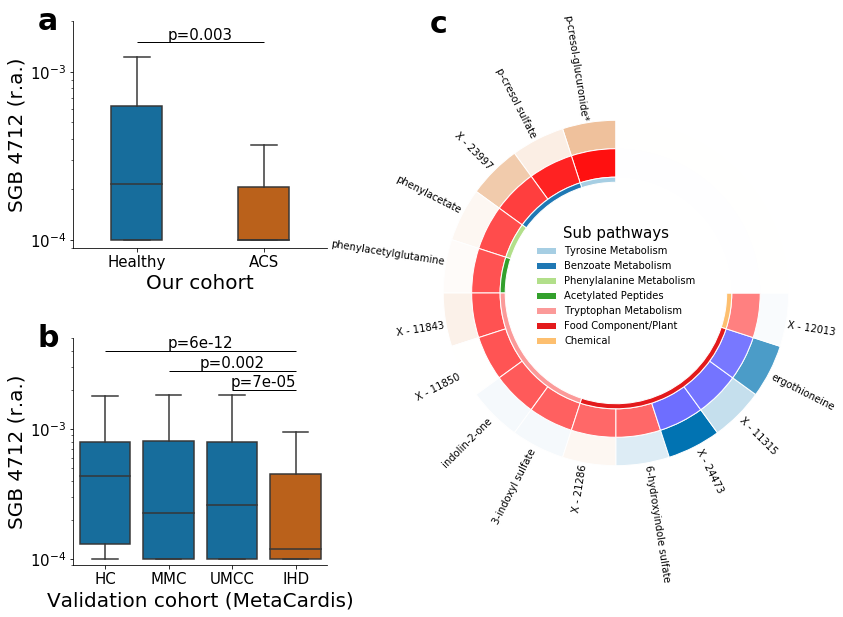

In [404]:
# df = circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS'].abs() > 5].copy()
# df = circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)) < 0.05/circ_heatmap_df_sorted.shape[0]].copy()
df = pd.DataFrame()
df = pd.concat((df_temp, pd.DataFrame(0, index=['']*int(df_temp.shape[0]/3), columns=df_temp.columns)), axis=0, sort=False)
df['BIOCHEMICAL'] = df['BIOCHEMICAL'].replace(0, '')
df['SUB_PATHWAY'] = df['SUB_PATHWAY'].replace(0, '')
# df.drop('').to_csv(os.path.join(curr_dir, 'circ_heatmap_df.csv'))

super_pathway_names = df['SUB_PATHWAY'].unique().tolist()
group_size=[df['SUB_PATHWAY'].value_counts().loc[i] for i in super_pathway_names]
 
cmaps = {'Healthy-ACS':[cm_healthy, cm_acs], 'Correlation with bacteria':[plt.cm.bwr_r]}
boundries = {k:None for k in cmaps}
boundries['Healthy-ACS'] = (-7, 7)
boundries['Correlation with bacteria'] = (-0.35, 0.35)
 
# fig, axes = plt.subplots(1, 3, figsize=(19, 7))
label_fontsize=20
tick_fontsize=15

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 5, wspace=.2, hspace=0.4)

our_box = fig.add_subplot(gs[0, :2])
val_box = fig.add_subplot(gs[1, :2])
circ = fig.add_subplot(gs[:, 3:])

# ax = axes[0]
# sns.boxplot(x='Group', y=k, data=mb_df.sort_values('Group'), hue='Cohort', ax=ax, showfliers=False, palette=sns.color_palette('Paired'))
# ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD/ACS'])
# # plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
# ax.set_yscale('log')
# ax.set_ylabel('Relative abundance of SGB 4712', fontsize=label_fontsize)
# ax.set_xlabel('Group', fontsize=label_fontsize)
# ax.tick_params(labelsize=tick_fontsize)
# leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
# ax.set_ylim((9e-5, 2e-2))
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# print (ax.get_xticks())

# t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.66)][k])
# xx=2.3
# ax.text(xx, 0.002,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
# ax.hlines(y=0.002, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')
# t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.33)][k])
# xx=1.8
# ax.text(xx, 0.003,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
# ax.hlines(y=0.003, xmin=xx-1, xmax=xx+1, linewidth=1, color='black')
# t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.)][k])
# xx=1.3
# ax.text(xx, 0.005,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
# ax.hlines(y=0.005, xmin=xx-1.5, xmax=xx+1.5, linewidth=1, color='black')
# t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 0)][k])
# xx=1.7
# ax.text(xx, 0.008,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
# ax.hlines(y=0.008, xmin=xx-1.5, xmax=xx+1.5, linewidth=1, color='black')

ax = our_box
sns.boxplot(x='Group', y=k, data=mb_df[mb_df.Cohort == 'Our cohort'].sort_values('Group'), ax=ax, showfliers=False, palette=[healthy_color, acs_color], width=0.4)
# ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD/ACS'])
ax.set_xticklabels(['Healthy', 'ACS'])
# plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
ax.set_yscale('log')
ax.set_ylabel('SGB 4712 (r.a.)', fontsize=label_fontsize)
ax.set_xlabel('Our cohort', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
ax.set_ylim((9e-5, 2e-3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print (ax.get_xticks())

t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 0)][k])
xx=0.5
ax.text(xx, 0.0015,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.0015, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')

ax = val_box
sns.boxplot(x='Group', y=k, data=mb_df[mb_df.Cohort == 'MetaCardis'].sort_values('Group'), ax=ax, showfliers=False, palette=[healthy_color, healthy_color, healthy_color, acs_color])
ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD'])
# ax.set_xticklabels(['Healthy', 'ACS'])
# plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
ax.set_yscale('log')
ax.set_ylabel('SGB 4712 (r.a.)', fontsize=label_fontsize)
ax.set_xlabel('Validation cohort (MetaCardis)', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
ax.set_ylim((9e-5, 5e-3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print (ax.get_xticks())

t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.66)][k])
xx=2.5
ax.text(xx, 0.002,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.002, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')
t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.33)][k])
xx=2.
ax.text(xx, 0.0028,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.0028, xmin=xx-1, xmax=xx+1, linewidth=1, color='black')
t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.)][k])
xx=1.5
ax.text(xx, 0.004,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.004, xmin=xx-1.5, xmax=xx+1.5, linewidth=1, color='black')
# t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 0)][k])
# xx=0.5
# ax.text(xx, 0.0015,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
# ax.hlines(y=0.0015, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')


ax = circ
# ax.axis('equal')

radius = 1.7
radius_step = 0.28

for layer in df.columns:
    if layer == 'BIOCHEMICAL' or layer == 'SUB_PATHWAY':
        continue
    if layer == 'Healthy-ACS':
        labels = df['BIOCHEMICAL']
#         labels = df.index
    else:
        labels = ['' for i in df.index]
    mypie2, texts = ax.pie([1 for i in range(df.shape[0])], radius=radius, labels=labels, rotatelabels=True,
                       labeldistance=1.,
                       colors=_get_scale_colors(cmaps[layer], df[layer], boundries=boundries[layer]), startangle=90)
#     if layer == 'Healthy-ACS':
#         for t in texts:
#             t.set_horizontalalignment('center')
#             t.set_verticalalignment('center')
    
    plt.setp(mypie2, width=radius_step, edgecolor='white')
    radius -= radius_step

mypie, _ = ax.pie(group_size, radius=radius,
#                   colors=sns.color_palette('Paired', len(super_pathway_names)), 
                  colors=sns.color_palette('Paired', len(super_pathway_names))[:-1] + [(1, 1, 1)],
                  textprops=dict(color='black', fontsize=50), startangle=90)
plt.setp(mypie, width=0.05, edgecolor='white')

legend = ax.legend(mypie, super_pathway_names,
                                  title="Sub pathways",
                                  loc="center",
                                  bbox_to_anchor=(0., 0, 1, 1.),
                                  fontsize=10, frameon=False)
legend.get_title().set_fontsize('15')

# from mpl_toolkits.axes_grid.inset_locator import inset_axes
# inset_axes = inset_axes(ax ,
#                     width="30%", # width = 30% of parent_bbox
#                     height="20%", # height : 1 inch
#                     bbox_to_anchor=(0., 0., 0.68, 0.95), bbox_transform=ax.transAxes)

fig.tight_layout()
plt.text(-0.1, 1.0, 'a', ha='center', va='center', transform=our_box.transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1.0, 'b', ha='center', va='center', transform=val_box.transAxes, fontsize=30, weight = 'bold')
plt.text(-0.2, 1.56, 'c', ha='center', va='center', transform=circ.transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(curr_dir, 'Figure_a-c_v2.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(curr_dir, 'Figure_a-c.png'), dpi=800, bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0 1]
[0 1 2 3]


Text(-0.1, 1.0, 'c')

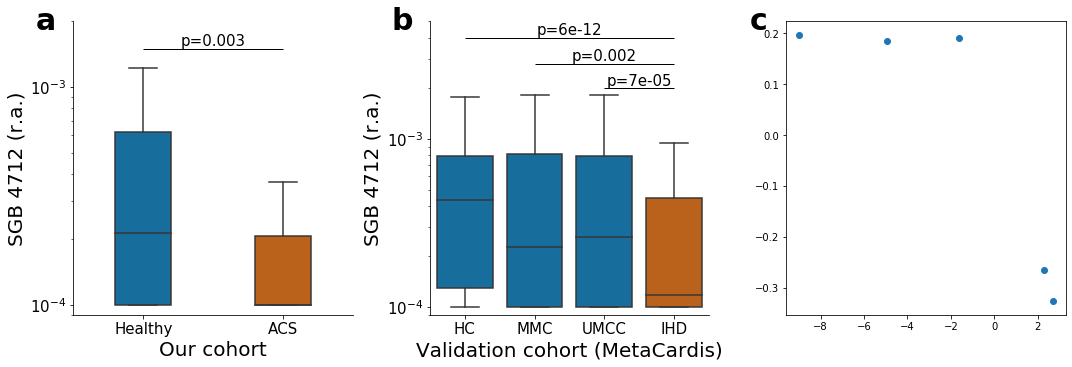

In [375]:
label_fontsize=20
tick_fontsize=15

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
sns.boxplot(x='Group', y=k, data=mb_df[mb_df.Cohort == 'Our cohort'].sort_values('Group'), ax=ax, showfliers=False, palette=[healthy_color, acs_color], width=0.4)
# ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD/ACS'])
ax.set_xticklabels(['Healthy', 'ACS'])
# plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
ax.set_yscale('log')
ax.set_ylabel('SGB 4712 (r.a.)', fontsize=label_fontsize)
ax.set_xlabel('Our cohort', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
ax.set_ylim((9e-5, 2e-3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print (ax.get_xticks())

t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 0)][k])
xx=0.5
ax.text(xx, 0.0015,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.0015, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')

ax = axes[1]
sns.boxplot(x='Group', y=k, data=mb_df[mb_df.Cohort == 'MetaCardis'].sort_values('Group'), ax=ax, showfliers=False, palette=[healthy_color, healthy_color, healthy_color, acs_color])
ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD'])
# ax.set_xticklabels(['Healthy', 'ACS'])
# plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
ax.set_yscale('log')
ax.set_ylabel('SGB 4712 (r.a.)', fontsize=label_fontsize)
ax.set_xlabel('Validation cohort (MetaCardis)', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
ax.set_ylim((9e-5, 5e-3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print (ax.get_xticks())

t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.66)][k])
xx=2.5
ax.text(xx, 0.002,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.002, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')
t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.33)][k])
xx=2.
ax.text(xx, 0.0028,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.0028, xmin=xx-1, xmax=xx+1, linewidth=1, color='black')
t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.)][k])
xx=1.5
ax.text(xx, 0.004,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.004, xmin=xx-1.5, xmax=xx+1.5, linewidth=1, color='black')

ax = axes[2]
plt.plot(df_temp['Healthy-ACS'], df_temp['Correlation with bacteria'], 'o')
# df_temp

fig.tight_layout()
plt.text(-0.1, 1.0, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1.0, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1.0, 'c', ha='center', va='center', transform=axes[2].transAxes, fontsize=30, weight = 'bold')

# plt.savefig(os.path.join(curr_dir, 'Figure_a-c_small.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(curr_dir, 'Figure_a-c.png'), dpi=800, bbox_inches='tight')

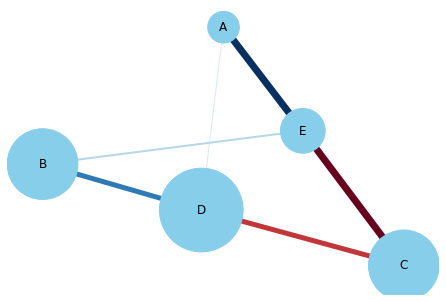

In [391]:
# os.system('pip install networkx --user')
# import networkx as nx

# import pandas as pd
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
 
# Build a dataframe with your connections
df = pd.DataFrame({ 'from':['A', 'B', 'C','A', 'B', 'C'], 'to':['D', 'D', 'D', 'E', 'E', 'E'], 'value':[1, 7, 5, -5, 2, -7]})
df
 
# Build your graph
G=nx.convert_matrix.from_pandas_edgelist(df, 'from', 'to', create_using=nx.Graph())
 
# Custom the nodes:
nx.draw(G, with_labels=True, node_color='skyblue', node_size=df['value'].abs()*1000, edge_color=df['value'], width=df['value'].abs(), edge_cmap=plt.cm.RdBu)


## merge boxplots into supplementary

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0 1]
[0 1 2 3]


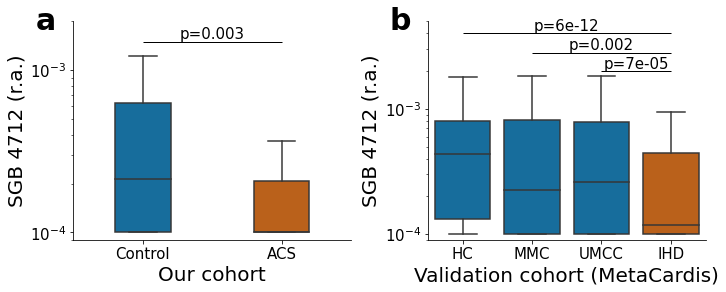

In [15]:
label_fontsize=20
tick_fontsize=15

fig, axes = plt.subplots(1, 2, figsize=(10, 4))


ax = axes[0]
sns.boxplot(x='Group', y=k, data=mb_df[mb_df.Cohort == 'Our cohort'].sort_values('Group'), ax=ax, showfliers=False, palette=[healthy_color, acs_color], width=0.4)
# ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD/ACS'])
ax.set_xticklabels(['Control', 'ACS'])
# plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
ax.set_yscale('log')
ax.set_ylabel('SGB 4712 (r.a.)', fontsize=label_fontsize)
ax.set_xlabel('Our cohort', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
ax.set_ylim((9e-5, 2e-3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print (ax.get_xticks())

t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'Our cohort') & (mb_df['Group'] == 0)][k])
xx=0.5
ax.text(xx, 0.0015,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.0015, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')

ax = axes[1]
sns.boxplot(x='Group', y=k, data=mb_df[mb_df.Cohort == 'MetaCardis'].sort_values('Group'), ax=ax, showfliers=False, palette=[healthy_color, healthy_color, healthy_color, acs_color])
ax.set_xticklabels(['HC', 'MMC', 'UMCC', 'IHD'])
# ax.set_xticklabels(['Healthy', 'ACS'])
# plt.xticks(['HC275', 'MMC269', 'UMCC222', 'IHD372'])
ax.set_yscale('log')
ax.set_ylabel('SGB 4712 (r.a.)', fontsize=label_fontsize)
ax.set_xlabel('Validation cohort (MetaCardis)', fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
leg = ax.legend(loc='upper left', fontsize=tick_fontsize, frameon=False)
ax.set_ylim((9e-5, 5e-3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
print (ax.get_xticks())

t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.66)][k])
xx=2.5
ax.text(xx, 0.002,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.002, xmin=xx-0.5, xmax=xx+0.5, linewidth=1, color='black')
t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.33)][k])
xx=2.
ax.text(xx, 0.0028,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.0028, xmin=xx-1, xmax=xx+1, linewidth=1, color='black')
t, p = mannwhitneyu(mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 1)][k], mb_df[(mb_df['Cohort'] == 'MetaCardis') & (mb_df['Group'] == 0.)][k])
xx=1.5
ax.text(xx, 0.004,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize, va='bottom')
ax.hlines(y=0.004, xmin=xx-1.5, xmax=xx+1.5, linewidth=1, color='black')

fig.tight_layout()
plt.text(-0.1, 1.0, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1.0, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
# plt.text(-0.2, 1.56, 'c', ha='center', va='center', transform=circ.transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(curr_dir, 'Extended_Data_figure_boxplots.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(curr_dir, 'Extended_Data_figure_boxplots.pdf'), dpi=300, bbox_inches='tight')

In [19]:
df = pd.DataFrame()
df = pd.concat((df_temp, pd.DataFrame(0, index=['']*int(df_temp.shape[0]/3), columns=df_temp.columns)), axis=0, sort=False)
df['BIOCHEMICAL'] = df['BIOCHEMICAL'].replace(0, '')
df['SUB_PATHWAY'] = df['SUB_PATHWAY'].replace(0, '')
# df.drop('').to_csv(os.path.join(curr_dir, 'circ_heatmap_df.csv'))

super_pathway_names = df['SUB_PATHWAY'].unique().tolist()
group_size=[df['SUB_PATHWAY'].value_counts().loc[i] for i in super_pathway_names]
 
cmaps = {'Healthy-ACS':[cm_healthy, cm_acs], 'Correlation with bacteria':[plt.cm.bwr_r]}
boundries = {k:None for k in cmaps}
boundries['Healthy-ACS'] = (-7, 7)
boundries['Correlation with bacteria'] = (-0.35, 0.35)

ax = circ
# ax.axis('equal')

radius = 1.7
radius_step = 0.28

for layer in df.columns:
    if layer == 'BIOCHEMICAL' or layer == 'SUB_PATHWAY':
        continue
    if layer == 'Healthy-ACS':
        labels = df['BIOCHEMICAL']
#         labels = df.index
    else:
        labels = ['' for i in df.index]
    mypie2, texts = ax.pie([1 for i in range(df.shape[0])], radius=radius, labels=labels, rotatelabels=True,
                       labeldistance=1.,
                       colors=_get_scale_colors(cmaps[layer], df[layer], boundries=boundries[layer]), startangle=90)
#     if layer == 'Healthy-ACS':
#         for t in texts:
#             t.set_horizontalalignment('center')
#             t.set_verticalalignment('center')
    
    plt.setp(mypie2, width=radius_step, edgecolor='white')
    radius -= radius_step

mypie, _ = ax.pie(group_size, radius=radius,
#                   colors=sns.color_palette('Paired', len(super_pathway_names)), 
                  colors=sns.color_palette('Paired', len(super_pathway_names))[:-1] + [(1, 1, 1)],
                  textprops=dict(color='black', fontsize=50), startangle=90)
plt.setp(mypie, width=0.05, edgecolor='white')

legend = ax.legend(mypie, super_pathway_names,
                                  title="Sub pathways",
                                  loc="center",
                                  bbox_to_anchor=(0., 0, 1, 1.),
                                  fontsize=10, frameon=False)
legend.get_title().set_fontsize('15')

In [18]:
required_data_for_plot = {'df':df}
with open(os.path.join(curr_dir, 'required_data_for_plot.pkl'), 'wb') as handle:
    pickle.dump(required_data_for_plot, handle)

# colorbar

In [35]:
df_temp

,BIOCHEMICAL,SUB_PATHWAY,Healthy-ACS,Correlation with bacteria
100006191,p-cresol-glucuronide*,Tyrosine Metabolism,2.698843,-0.326346
100001315,p-cresol sulfate,Benzoate Metabolism,0.719160,-0.302568
X - 23997,X - 23997,Benzoate Metabolism,2.271898,-0.263596
100000011,phenylacetate,Phenylalanine Metabolism,0.380995,-0.245748
100001417,phenylacetylglutamine,Acetylated Peptides,0.203488,-0.236824
X - 11843,X - 11843,Tryptophan Metabolism,0.624293,-0.235235
X - 11850,X - 11850,Tryptophan Metabolism,0.010422,-0.234544
100004318,indolin-2-one,Food Component/Plant,-0.297747,-0.224704
100000467,3-indoxyl sulfate,Tryptophan Metabolism,-0.313810,-0.217847
X - 21286,X - 21286,Tryptophan Metabolism,0.358907,-0.207758


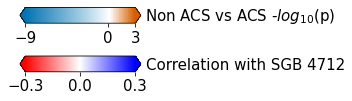

In [58]:
tick_fontsize = 15
label_fontsize = 15

fig, axes = plt.subplots(2, 1, figsize=(5, 1.5))

ax = axes[0]
norm1 = MidpointNormalize(vmin=-9, 
                          vmax=3, 
                          midpoint=-2.5)
cmap1 = _get_scale_colors([cm_healthy, cm_acs], df_temp['Healthy-ACS'], return_cmap=True, boundries=[-9, 3])
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap1,
                                norm=norm1, ticks=[-9, 0, 3],
                                orientation='horizontal', extend='both')
# cb1.set_label('Healthy-ACS ($log_{10}$ pvalue)', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
# cb1.ax.set_xticks([-9, 0, 3]) 
# cb1.ax.set_xticklabels([-9, 0, 3]) 
ax.text(4, -7, 'Non ACS vs ACS -$log_{10}$(p)', fontsize=label_fontsize)

ax = axes[1]
norm1 = mpl.colors.Normalize(vmin=-0.3, 
                                                 vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.bwr_r,
                                norm=norm1, ticks=[-0.3, 0, 0.3], 
                                orientation='horizontal', extend='both')
# cb1.set_label('Microbiome $R^2$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
ax.text(0.3 * 1.2, -0.2, 'Correlation with SGB 4712', fontsize=label_fontsize)

fig.tight_layout()
plt.savefig(os.path.join(curr_dir, 'legend.png'), dpi=300)
# plt.savefig(os.path.join(curr_dir, 'legend.png'), dpi=800)

# Find samples for molecule identification

In [85]:
samps1 = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v4/dataframes/samps1.csv', index_col=0)
pnp1_full_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')

Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.


In [96]:
mapping = {}
for s in pnp1_full_data.loc[candidates, 'SerumName']:
    print (s.split('_')[0], s, s.split('_')[-1])
    mapping[int(s.split('_')[0])] = s.split('_')[-1]
mapping

121123 121123_1_SID3371 SID3371
535831 535831_1_SID3267 SID3267
679672 679672_1_SID6950 SID6950
585964 585964_1_SID659 SID659
105043 105043_1_SID2443 SID2443
789535 789535_1_SID6047 SID6047
463979 463979_1_SID1679 SID1679
640111 640111_1_SID1591 SID1591
898339 898339_1_SID5957 SID5957
222311 222311_1_SID1659 SID1659


{121123: 'SID3371',
 535831: 'SID3267',
 679672: 'SID6950',
 585964: 'SID659',
 105043: 'SID2443',
 789535: 'SID6047',
 463979: 'SID1679',
 640111: 'SID1591',
 898339: 'SID5957',
 222311: 'SID1659'}

In [92]:
candidates = [121123, 535831, 679672, 585964, 105043, 789535, 463979, 640111, 898339, 222311]

In [99]:
cs = ['X - 24473', 'X - 11315', 'X - 23997']
(pnp_data_metabolon.loc[:, cs].dropna(how='all').sort_values(['X - 24473', 'X - 23997'])\
     .apply(lambda x: x.rank()).loc[candidates] > 100).rename(index=mapping)\
     .replace({True:'High', False:'Low'}).to_csv(os.path.join(curr_dir, 'X-24473_X-11315_X-23997_10samples.csv'))
# pd.DataFrame.rank(pnp_data_metabolon['X - 24473'])

TypeError: 'list' object is not callable

In [36]:
pnp_data_metabolon[candidates].dropna(how='all').sort_values(['X - 24473', 'X - 23997']).apply(lambda x: x.rank()).head(30)

KeyError: "None of [Int64Index([866974, 121123, 313370, 535831, 679672, 585964, 105043, 789535,\n            463979, 640111, 898339],\n           dtype='int64')] are in the [columns]"

# Rank samples by SGB 4712

In [2]:
from LabData.DataLoaders.GutMBLoader import GutMBLoader

In [3]:
mb_data = GutMBLoader().get_data('segata_species', study_ids=['10K'])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
s = 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__unknown|s__unknown|fSGB__1439|gSGB__3527|sSGB__4712'
mb_data.df.loc[:, s].sort_values(ascending=False).head(10)

SampleName
22001804500301_v2_fullrun    0.033749
22002003560638_v2_fullrun    0.019495
22001804500904_v2_fullrun    0.012417
22002003581274_v2_fullrun    0.011170
22001804504720_v2_fullrun    0.010619
22001804503420_v2_fullrun    0.010521
22001804500392_v2_fullrun    0.010285
22001804503014_v2_fullrun    0.009506
22001804500218_v2_fullrun    0.009026
22002003561043_v2_fullrun    0.008502
Name: k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__unknown|s__unknown|fSGB__1439|gSGB__3527|sSGB__4712, dtype: float64

In [13]:

mb_data.df_metadata.loc[mb_data.df.loc[:, s].sort_values(ascending=False).head(10).index]['RegistrationCode'].values

array(['10K_7119544168', '10K_9608396847', '10K_4169625169',
       '10K_5831619572', '10K_8830851455', '10K_4475819920',
       '10K_8242517689', '10K_1517346703', '10K_8886234961',
       '10K_8215772443'], dtype=object)